In [20]:
import torch
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
import torch

## PLAN!!!

### Things to do:
- Could investigate the dataset(s), see if there is any pattern from plotting etc. (Seems quite dead)
- Create models from list below:

#### Models to consider
- ~~Polynomial Regression using Basis Expansion (Scikit-learn mostly)~~
- Logistic Regression with regularization (L1 or L2)
- Fully connected Neural Network (Probably PyTorch) (Also works scikit-learn using sklearn.neural_network.MLPClassifier)
- Investigate how to use ChatGPT or something
- Support Vector Machine (with non-linear kernel? kernel='rbf' for scikit-learn.)
- Look at using a Tree-based model? (sklearn.tree.DecisionTreeClassifier)
- Ensemble Method: Random Forest Classifier (Also scikit-learn probably)

#### Considerations:
- For each model, there are most likely hyperparameters that can be tuned.
- E.g. polynomial regression can use L2 or L1 (or both) regularization to avoid overfitting, this has a parameter that can be tuned
- Haven't looked into the others but probably just ask ChatGPT
- Can use k-fold cross validation to validate hyper-parameters (or just use validation test set, k-fold would be more robust though)
- Trial and error to find a decent starting point then search in the parameter space around it using for loops (GridSearch I guess)
- HOPE IT WORKS!

(60000,)


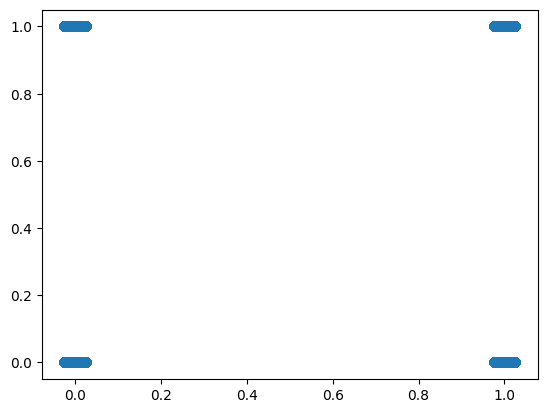

(60000, 30)
(60000,)
(60000,)


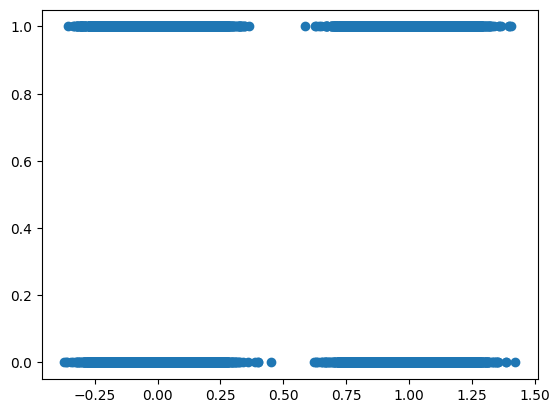

(60000, 30)
(60000,)
(60000,)


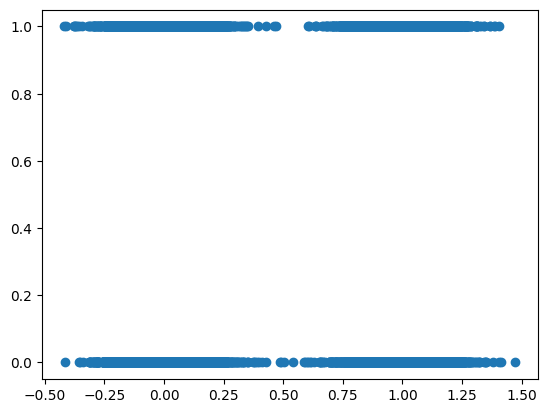

(60000, 30)
(60000,)
(60000,)


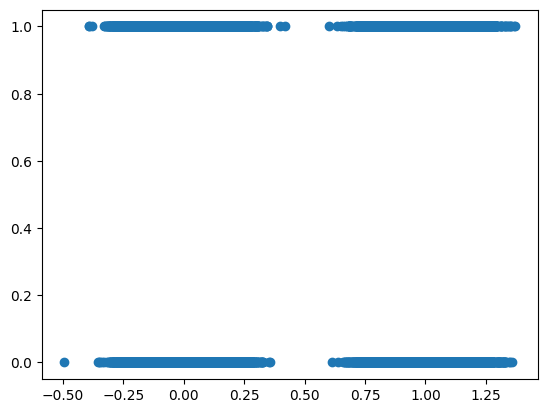

(60000, 30)
(60000,)
(60000,)


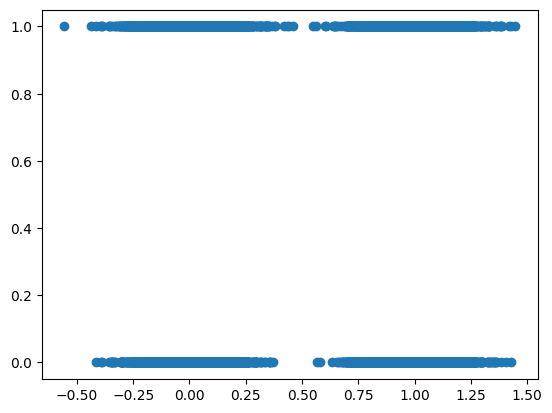

(60000, 30)
(60000,)
(60000,)


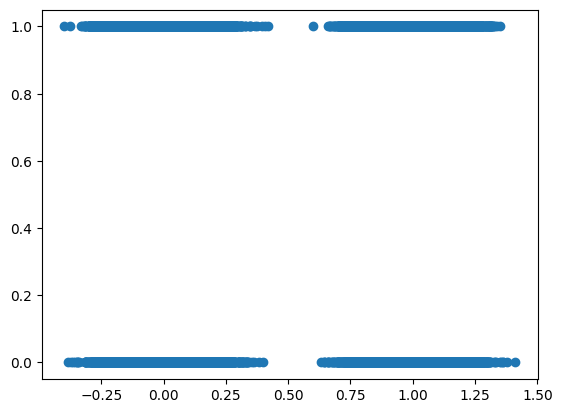

(60000, 30)
(60000,)
(60000,)


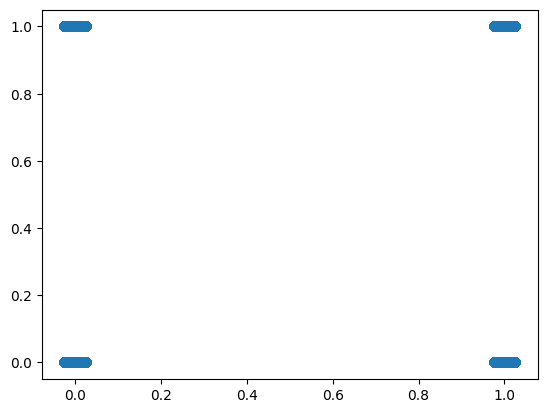

(60000, 30)
(60000,)
(60000,)


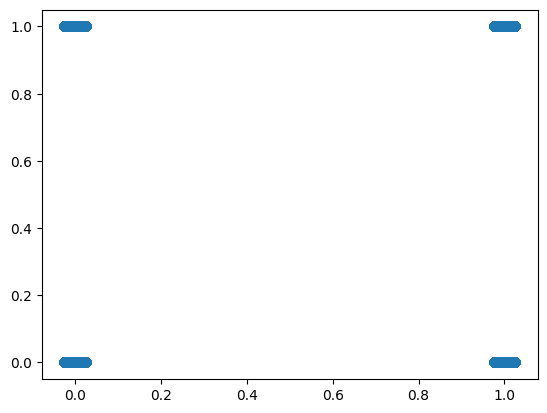

(60000, 30)
(60000,)
(60000,)


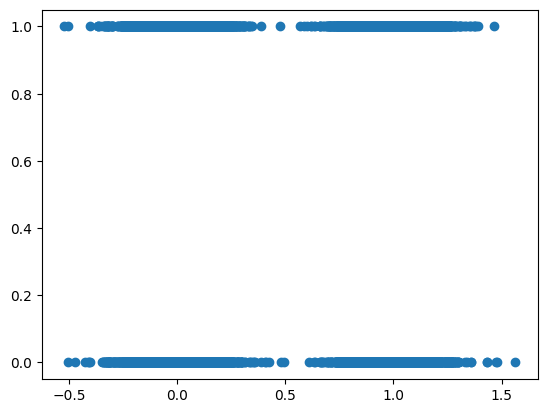

(60000, 30)
(60000,)
(60000,)


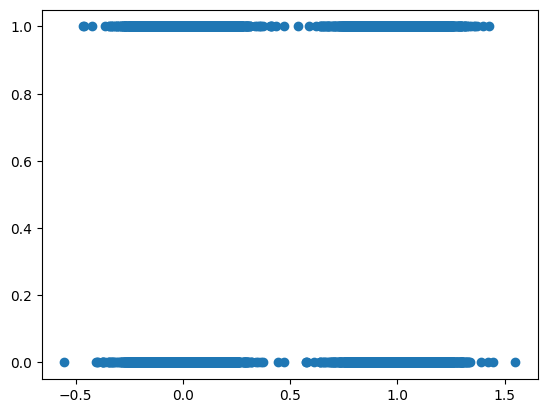

(60000, 30)
(60000,)
(60000,)


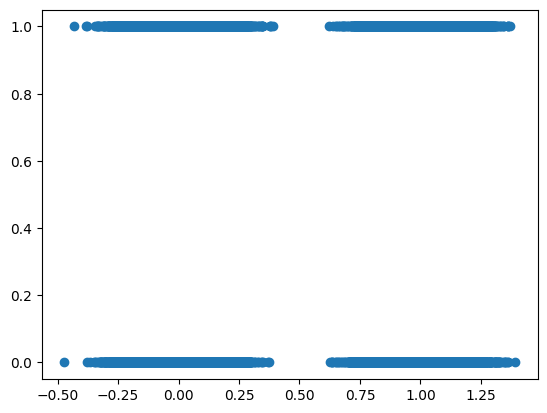

(60000, 30)
(60000,)
(60000,)


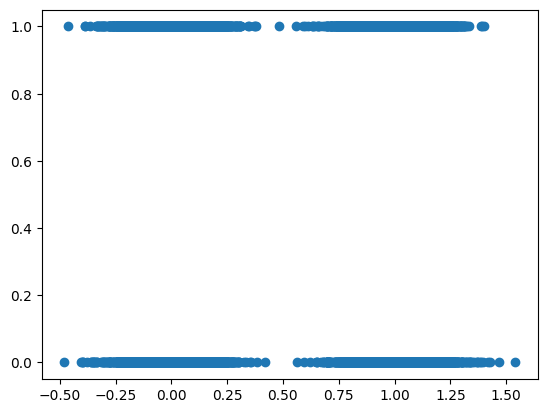

(60000, 30)
(60000,)
(60000,)


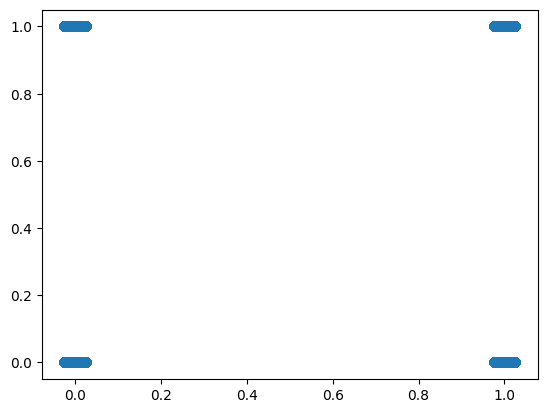

(60000, 30)
(60000,)
(60000,)


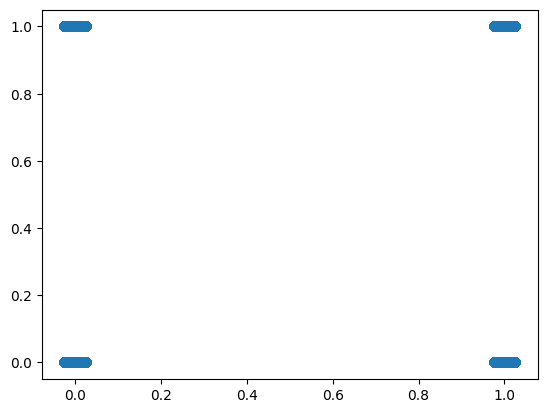

(60000, 30)
(60000,)
(60000,)


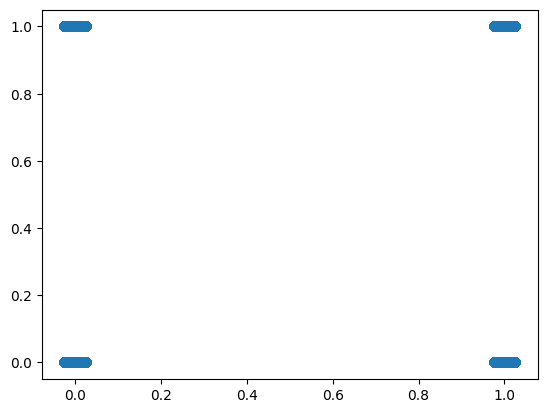

(60000, 30)
(60000,)
(60000,)


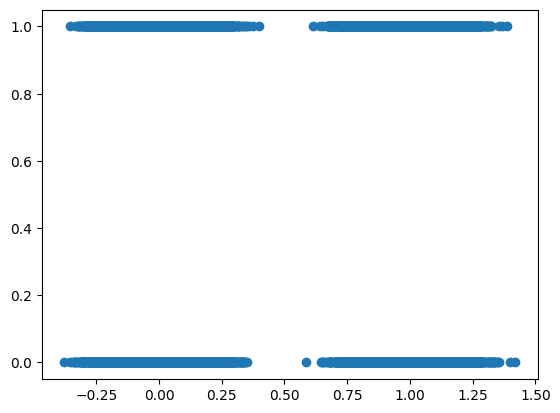

(60000, 30)
(60000,)
(60000,)


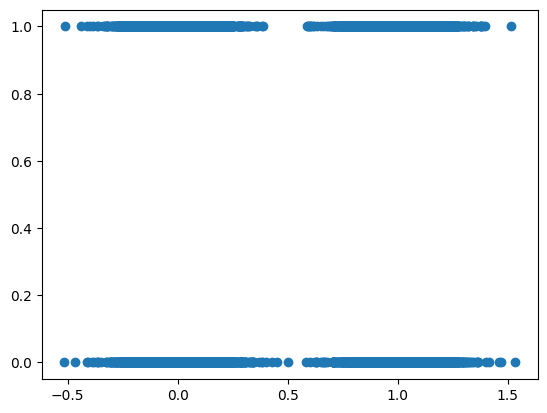

(60000, 30)
(60000,)
(60000,)


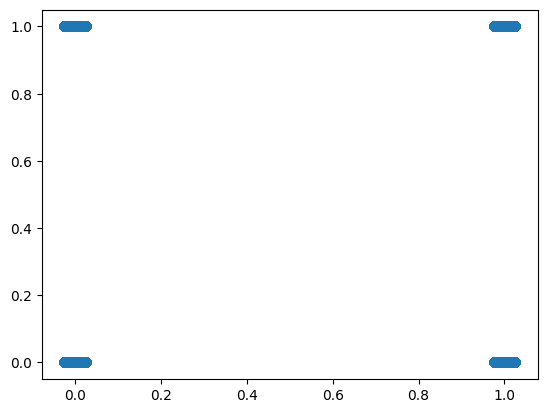

(60000, 30)
(60000,)
(60000,)


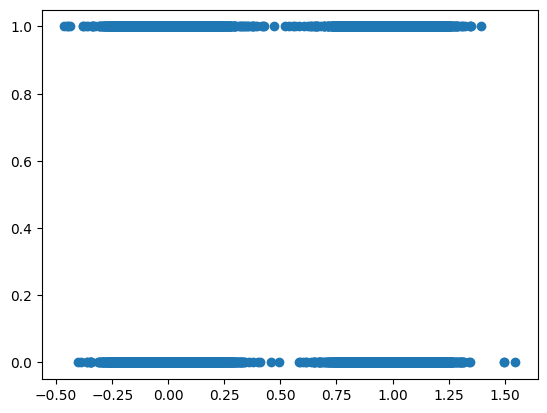

(60000, 30)
(60000,)
(60000,)


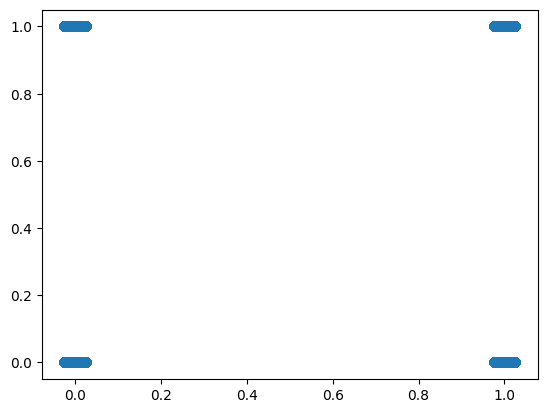

(60000, 30)
(60000,)
(60000,)


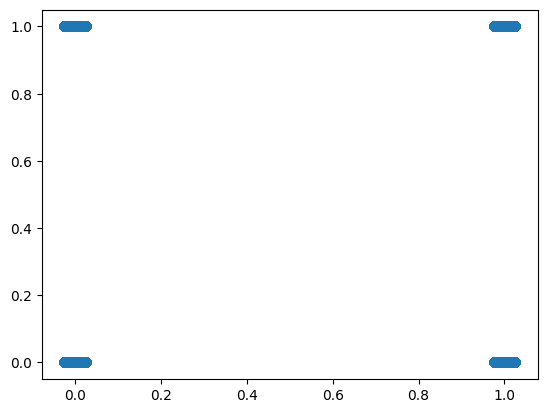

(60000, 30)
(60000,)
(60000,)


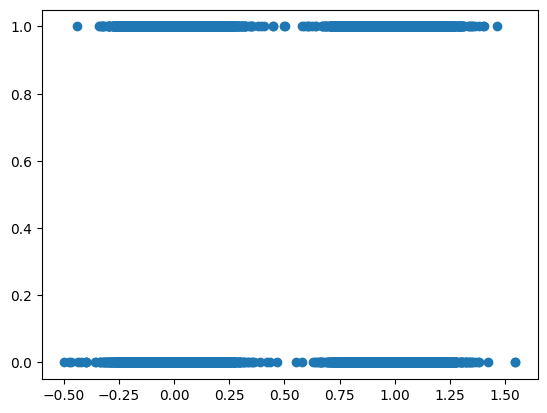

(60000, 30)
(60000,)
(60000,)


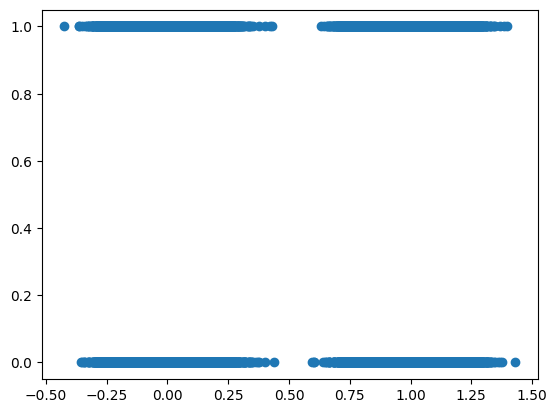

(60000, 30)
(60000,)
(60000,)


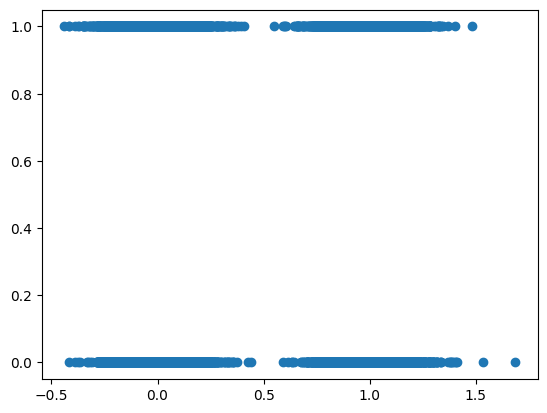

(60000, 30)
(60000,)
(60000,)


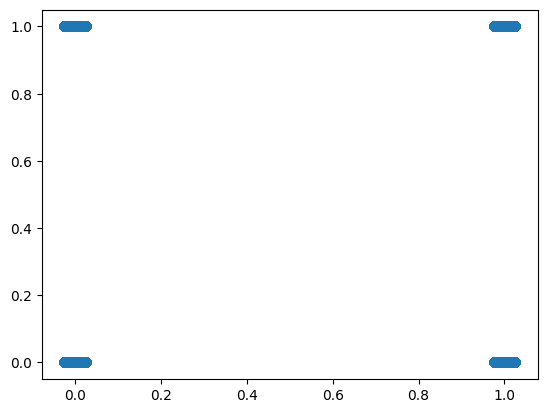

(60000, 30)
(60000,)
(60000,)


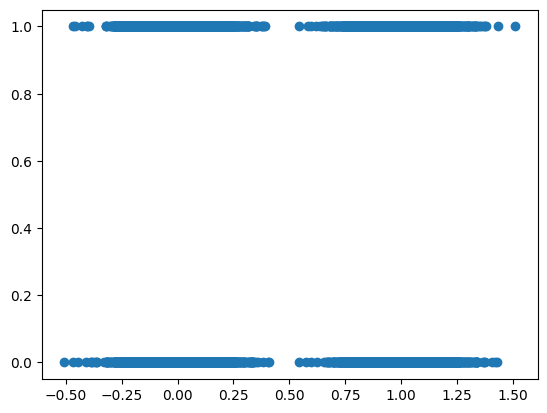

(60000, 30)
(60000,)
(60000,)


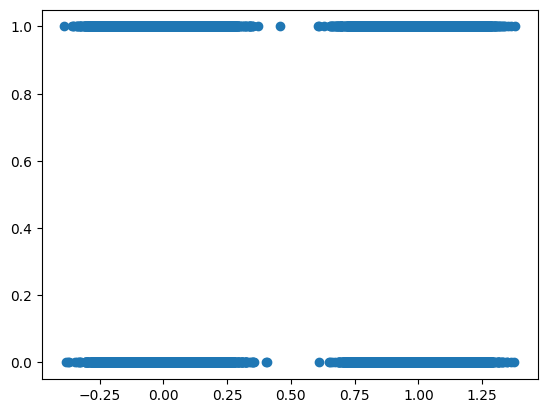

(60000, 30)
(60000,)
(60000,)


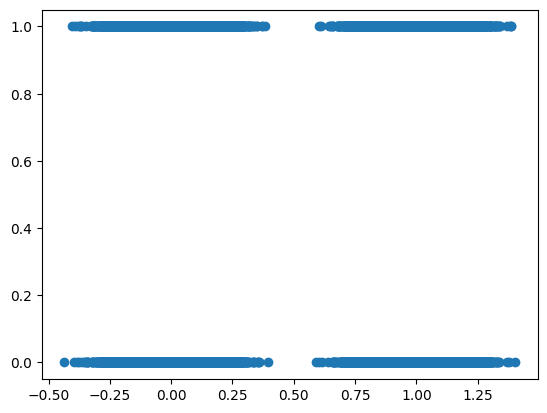

(60000, 30)
(60000,)
(60000,)


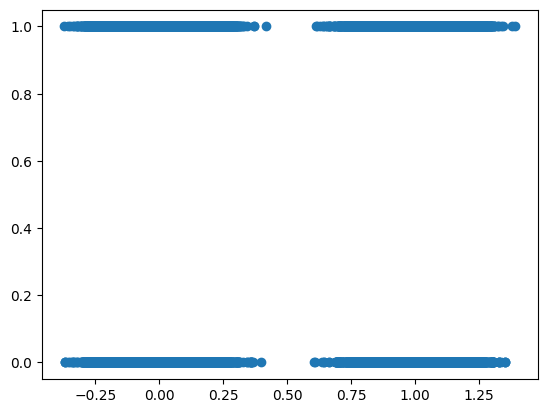

(60000, 30)
(60000,)
(60000,)


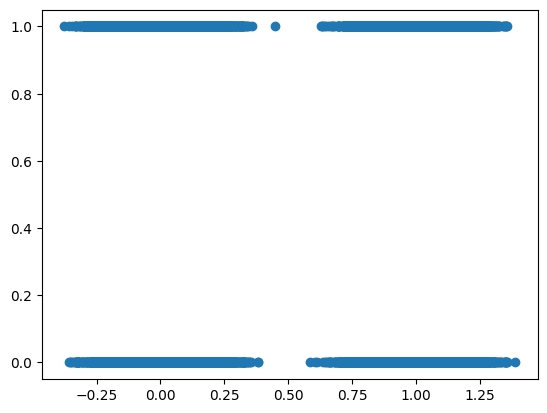

(60000, 30)
(60000,)


(array([[ 1.0180902 ,  0.94495875,  0.9969711 , ...,  0.8443581 ,
         -0.0470547 , -0.01600194],
        [ 0.97621644,  1.0668855 ,  0.01162091, ...,  1.0854539 ,
          1.2297008 ,  0.04107817],
        [-0.00905149,  0.85840815,  1.0780299 , ..., -0.1137795 ,
          0.05377677,  0.02774266],
        ...,
        [ 0.00417284,  0.9290962 , -0.01721166, ...,  1.0254418 ,
          1.1416477 ,  1.1206903 ],
        [ 0.01133533,  0.2158203 ,  1.0966631 , ..., -0.08489116,
          0.00307082,  0.0210612 ],
        [ 1.0138273 ,  0.04731968,  0.9794971 , ...,  0.8709142 ,
          0.16066316,  1.0315189 ]], dtype=float32),
 array([0, 0, 0, ..., 1, 0, 1], dtype=int64))

In [28]:
# Data investigation
def load_data(n_to_load):
    # Possible n's include: 9, 12, 15, 18, 24, 30, 45.
    X = np.load('Datasets/kryptonite-%s-X.npy'%(n_to_load))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(n_to_load))

    for n in range(X.shape[1]):
        print(X[:, n].shape)
        plt.scatter(X[:, n], y)
        plt.show()
        print(X.shape)
        print(y.shape)

    return X, y

load_data(30)

## Polynomial regression attempt

Firstly start with polynomials of degree 2 (up to 3) since for datasets n=45, having larger order polynomials will probably cause the model to overfit.

Add in regularization:
- Could investigate using Ridge Regression (L2) or Lasso Regression (L1) individually and tune hyperparameters there.
- Could investigate ElasticNet which combines both L2 and L1 regularisation 

In [ ]:
def polynomial_main(n, e):
    pass



In [ ]:
# Load data
def main(n, e):
    X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(n)) 

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)  # 60% training
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validation, 20% test

    main()
    # Ideas to try:
    # Polynomial Regression with Basis Expansion (?)
    # Fully Connected Neural Network
    # Support Vector Regression
    # Random Forest Regression
    # GPT-4?